# Local Cloud Plugin Architecture 
This notebook contains a local-cloud control plane with plugin contracts and dependency-aware execution. While not a core requirement for the capstone, it is a supplementary architecture artifact used for extending the concept as an open source project repository.


## Motivation

A local-cloud plugin architecture is used to separate control-plane orchestration from domain plugins (ingest, risk, RCA, agentic adjudication, governance, storage). This separation reduces coupling and makes subsystem ownership explicit, which is essential for audited industrial deployments.

The runtime focuses on operational evidence rather than conceptual claims: plugin execution logs, policy-gate invariants, and materialized data outputs (SQLite/Parquet). In this project, the local-cloud extension provides a practical bridge between notebook experimentation and system-architecture implementation patterns expected in production engineering.


## 1) Imports and Path Setup

We import the local-cloud runtime and analysis libraries, then resolve the project root so the notebook runs from either `P7/` or the repository root.


In [11]:
import json
import sqlite3
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

ROOT = Path.cwd()
if not (ROOT / 'local_cloud').exists() and (ROOT / 'P7' / 'local_cloud').exists():
    ROOT = ROOT / 'P7'

if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

print('Resolved ROOT:', ROOT)
print('local_cloud exists:', (ROOT / 'local_cloud').exists())
print('integrated packets exists:', (ROOT / 'outputs' / 'integrated_packets.jsonl').exists())


Resolved ROOT: c:\Users\Ohara\Desktop\__Udacity\__MSc_Project\P7
local_cloud exists: True
integrated packets exists: True


## 2) Run Local Cloud Control Plane

This step executes the plugin registry in dependency order: ingest, risk, RCA, agent, governance, storage. Outputs are written to `outputs/local_cloud_summary.json` and local storage artifacts.


In [12]:
from local_cloud.runtime import run_local_cloud

run_ctx = run_local_cloud(ROOT, ROOT / 'outputs')

summary_path = ROOT / 'outputs' / 'local_cloud_summary.json'
summary = json.loads(summary_path.read_text(encoding='utf-8'))

print('Summary path:', summary_path)
display(pd.DataFrame(summary['execution_log']))
display(pd.DataFrame([summary.get('risk_summary', {})]))
display(pd.DataFrame([summary.get('agent_summary', {})]))
display(pd.DataFrame([summary.get('governance_summary', {})]))
display(pd.DataFrame([summary.get('storage_summary', {})]))


Summary path: c:\Users\Ohara\Desktop\__Udacity\__MSc_Project\P7\outputs\local_cloud_summary.json


,plugin,status,started_utc,error
0,ingest,ok,2026-02-21T07:54:17.714265+00:00,
1,risk,ok,2026-02-21T07:54:17.735254+00:00,
2,rca,ok,2026-02-21T07:54:17.750931+00:00,
3,agent,ok,2026-02-21T07:54:17.753435+00:00,
4,governance,ok,2026-02-21T07:54:17.815700+00:00,
5,storage,ok,2026-02-21T07:54:17.817811+00:00,


,mean_risk,high_risk_count_ge_0_80,zone_mean_risk
0,0.742,2,"{'IT_DMZ': 0.72, 'OT_CONTROL': 0.875, 'OT_SUPE..."


,meta_rows,disagreement_rate,hitl_required_rate,meta_decisions_path,meta_rebuilt_in_run
0,5,0.2,0.4,c:\Users\Ohara\Desktop\__Udacity\__MSc_Project...,True


,policy_fail_count,policy_gate_invariant_violations,status
0,3,0,pass


,sqlite_path,parquet_path,parquet_written,parquet_error
0,c:\Users\Ohara\Desktop\__Udacity\__MSc_Project...,c:\Users\Ohara\Desktop\__Udacity\__MSc_Project...,True,


## 3) Plugin Dependency Graph

A dependency graph clarifies orchestration order and separation of responsibilities, which is useful for architecture reviews and thesis communication.

The local cloud plugin architecture is visualized below: 
![Local Cloud](diagrams/local-cloud.png)




Resolved order: ['ingest', 'risk', 'rca', 'agent', 'governance', 'storage']


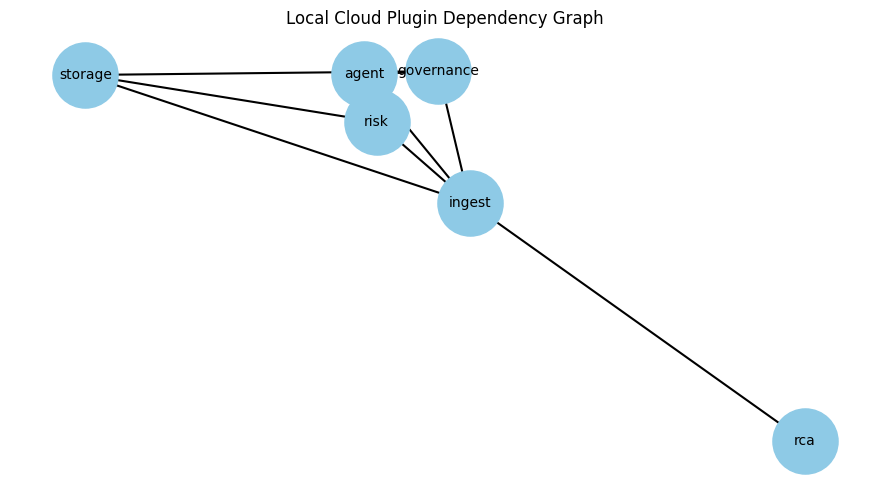

In [16]:
from local_cloud.runtime import LocalCloudControlPlane

cp = LocalCloudControlPlane(ROOT / 'outputs')
order = cp.registry.resolve_order()
print('Resolved order:', order)

G = nx.DiGraph()
for name in cp.registry.names():
    G.add_node(name)
for name in cp.registry.names():
    plugin = cp.registry.get(name)
    for dep in plugin.depends_on:
        G.add_edge(dep, name)

plt.figure(figsize=(9, 5))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_size=2200, node_color='#8ecae6')
nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='-|>', arrowsize=18, width=1.5)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title('Local Cloud Plugin Dependency Graph')
plt.axis('off')
plt.tight_layout()
plt.show()


## 4) Data Engineering Materialization Check

The storage plugin writes a SQLite table and (optionally) Parquet. This demonstrates a practical local data-engineering handoff surface.


In [14]:
sqlite_path = ROOT / 'outputs' / 'local_cloud_packets.db'
print('SQLite exists:', sqlite_path.exists(), sqlite_path)

if sqlite_path.exists():
    conn = sqlite3.connect(sqlite_path)
    zone_counts = pd.read_sql_query(
        'SELECT zone, decision_type, COUNT(*) AS n FROM integrated_packets GROUP BY zone, decision_type ORDER BY zone, decision_type',
        conn,
    )
    conn.close()
    display(zone_counts)

parquet_path = ROOT / 'outputs' / 'local_cloud_packets.parquet'
print('Parquet exists:', parquet_path.exists(), parquet_path)


SQLite exists: True c:\Users\Ohara\Desktop\__Udacity\__MSc_Project\P7\outputs\local_cloud_packets.db


,zone,decision_type,n
0,IT_DMZ,refuse,1
1,OT_CONTROL,escalate,2
2,OT_SUPERVISORY,escalate,2


Parquet exists: True c:\Users\Ohara\Desktop\__Udacity\__MSc_Project\P7\outputs\local_cloud_packets.parquet


## 5) Failure Drill (Plugin Fault Injection)

This drill intentionally passes a bad `meta_decisions_path` to validate failure containment and explicit error logging in the control plane.


In [15]:
from local_cloud.runtime import LocalCloudControlPlane, default_context

faulty = default_context(ROOT)
faulty['meta_decisions_path'] = str(ROOT / 'outputs' / 'meta_decisions_DOES_NOT_EXIST.jsonl')

cp_fault = LocalCloudControlPlane(ROOT / 'outputs')
fault_ctx = cp_fault.run(faulty)

fault_summary = json.loads((ROOT / 'outputs' / 'local_cloud_summary.json').read_text(encoding='utf-8'))
display(pd.DataFrame(fault_summary['execution_log']))
print('Last status:', fault_summary['execution_log'][-1]['status'])
print('Last error:', fault_summary['execution_log'][-1]['error'])


,plugin,status,started_utc,error
0,ingest,ok,2026-02-21T07:54:18.126543+00:00,
1,risk,ok,2026-02-21T07:54:18.128052+00:00,
2,rca,ok,2026-02-21T07:54:18.129187+00:00,
3,agent,ok,2026-02-21T07:54:18.130191+00:00,
4,governance,ok,2026-02-21T07:54:18.148145+00:00,
5,storage,ok,2026-02-21T07:54:18.150949+00:00,


Last status: ok
Last error: 


## 6) Notes

- This run executed all six plugins successfully (`status=ok`) in dependency order.
- Governance checks passed with `policy_gate_invariant_violations=0` and `policy_fail_count=3`.
- Agent plugin outputs were built in-run with `meta_rows=5`, `disagreement_rate=0.2`, and `hitl_required_rate=0.4`.
- Storage materialization succeeded to both SQLite and Parquet, providing an operational handoff surface for downstream analytics.

